# Uniwersalny symulator algorytmów planowania procesów
***
Sławomir Górawski  
2018-01-21

In [1]:
from abc import ABC, abstractmethod
from collections import deque
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

## Program

In [3]:
class Process:
    """Approximation of a process"""
    
    def __init__(self, time_needed):
        if not time_needed > 0:
            raise ValueError("Time must be positive")
        self.time_needed = int(time_needed)
        self.time_waiting = 0
    
    def is_finished(self):
        return self.time_needed == 0
    
    def work(self):
        self.time_needed -= 1
    
    def wait(self):
        self.time_waiting += 1

In [4]:
class Scheduler(ABC):
    """Abstract base class for schedulers"""
    
    def __init__(self):
        self.current = None
        self.time = 0
        self.waiting_times = []
    
    @abstractmethod
    def add(self, process):
        pass
    
    @abstractmethod
    def switch(self):
        pass
    
    def tick(self):
        self.time += 1
        if self.current is None or self.current.is_finished():
            self.switch()
            if self.current is None:
                return
            self.waiting_times.append(
                (self.time, self.current.time_waiting))
        self.current.work()
        for process in self.waiting:
            process.wait()

In [5]:
class FCFS(Scheduler):
    """First Come First Served"""
    
    def __init__(self):
        super().__init__()
        self.waiting = deque()
    
    def add(self, process):
        self.waiting.append(process)
        if self.current is None:
            self.switch()
    
    def switch(self):
        self.current = (self.waiting.popleft()
                        if self.waiting else None)

In [6]:
class SJF(Scheduler):
    """Shortest Job First"""
    
    def __init__(self, enable_preemption=False):
        super().__init__()
        self.waiting = []
        self.preemption_enabled = enable_preemption
    
    def add(self, process):
        self.waiting.append(process)
        if self.preemption_enabled:
            self.switch()
    
    def switch(self):
        if self.waiting:
            next_process = min(self.waiting,
                               key=lambda x: x.time_needed)
            if self.current is None or self.current.is_finished():
                self.waiting.remove(next_process)
                self.current = next_process
                return
            if next_process.time_needed < self.current.time_needed:
                preemptied_process = deepcopy(self.current)
                self.waiting.remove(next_process)
                self.waiting.append(preemptied_process)
                self.current = next_process

In [7]:
class RR(Scheduler):
    """Round Robin"""
    
    def __init__(self, quant):
        super().__init__()
        self.waiting = deque()
        self.quant = quant
        self.clock = 0
    
    def add(self, process):
        if self.current is None:
            self.current = process
        else:
            self.waiting.append(process)
    
    def switch(self):
        self.clock = 0
        if self.current is None or self.current.is_finished():
            self.current = (self.waiting.popleft()
                            if self.waiting else None)
        else:
            preemptied_process = deepcopy(self.current)
            self.waiting.append(preemptied_process)
            self.current = self.waiting.popleft()
    
    def tick(self):
        self.time += 1
        self.clock += 1
        if (self.current is None
                or self.current.is_finished()
                or self.clock >= self.quant):
            self.switch()
            if self.current is not None:
                self.waiting_times.append(
                    (self.time, self.current.time_waiting))
        if self.current is None:
            return
        
        self.current.work()
        for process in self.waiting:
            process.wait()

## Testy

In [8]:
class Test:
    """docstring"""
    
    def __init__(self, time, process_time_bounds, process_time_distribution,
                 process_spawning_period, rr_quant=100, title="Przebieg symulacji"):
        # TEST PARAMETERS
        self.time = time
        self.process_time_bounds = process_time_bounds
        self.process_time_distribution = process_time_distribution
        self.process_spawning_period = process_spawning_period
        self.title = title
        
        # SCHEDULERS INITIALIZATION
        self.fcfs = FCFS()
        self.sjf = SJF()
        self.srtf = SJF(enable_preemption=True)
        self.rr = RR(rr_quant)
    
    def test(self):
        for t in range(self.time):
            for scheduler in [self.fcfs, self.sjf, self.srtf, self.rr]:
                if t % self.process_spawning_period == 0:
                    scheduler.add(self.spawn_process())
                scheduler.tick()
        
        fcfs_times = list(zip(*self.fcfs.waiting_times))
        sjf_times = list(zip(*self.sjf.waiting_times))
        srtf_times = list(zip(*self.srtf.waiting_times))
        rr_times = list(zip(*self.rr.waiting_times))
        
        print("FCFS waiting times mean: %f" % np.mean(fcfs_times[1]))
        print("SJF waiting times mean:  %f" % np.mean(sjf_times[1]))
        print("SRTF waiting times mean: %f" % np.mean(srtf_times[1]))
        print("RR waiting times mean:   %f" % np.mean(rr_times[1]))
        
        self.plot_results(fcfs_times, sjf_times, srtf_times, rr_times)
    
    def spawn_process(self):
        time_needed = {
            'uniform': lambda: np.random.uniform(*self.process_time_bounds),
            'normal': lambda: np.random.normal(
                np.mean(self.process_time_bounds), (self.process_time_bounds[1]
                     - self.process_time_bounds[0])/8)
        }[self.process_time_distribution]()
        return Process(time_needed)
                
    def plot_results(self, fcfs_times, sjf_times, srtf_times, rr_times):
        # LINES
        style = {'marker': 'd', 'linewidth': 1}
        rr_plot, = plt.plot(
            *rr_times, **style, label="RR")
        fcfs_plot, = plt.plot(
            *fcfs_times, **style, label="FCFS")
        sjf_plot, = plt.plot(
            *sjf_times, **style, label="SJF")
        srtf_plot, = plt.plot(
            *srtf_times, **style, label="SRTF")
        
        # LEGEND AND DESCRIPTION
        plt.legend(
            handles=[fcfs_plot, sjf_plot, srtf_plot, rr_plot], fontsize=15)
        plt.title(self.title, fontsize=20, fontweight="bold")
        plt.xlabel("czas [ms]")
        plt.ylabel("łączny czas oczekiwania")

## Przykłady

## 1
Równomierne przybywanie procesów o podobnym czasie wykonywania

FCFS waiting times mean: 136.361111
SJF waiting times mean:  35.810811
SRTF waiting times mean: 43.542857
RR waiting times mean:   182.638889


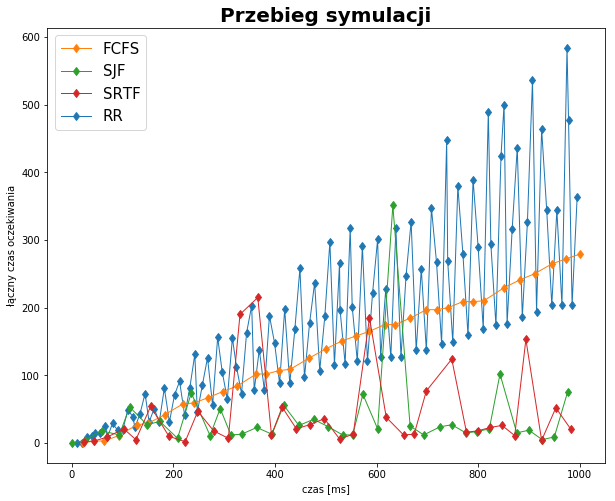

In [9]:
Test(1000, (20, 40), 'uniform', 20, 10).test()

## 2
Większy rozrzut czasów wykonania; kwant czasu w RR równy 10ms

FCFS waiting times mean: 42.000000
SJF waiting times mean:  34.157895
SRTF waiting times mean: 57.823529
RR waiting times mean:   45.543689


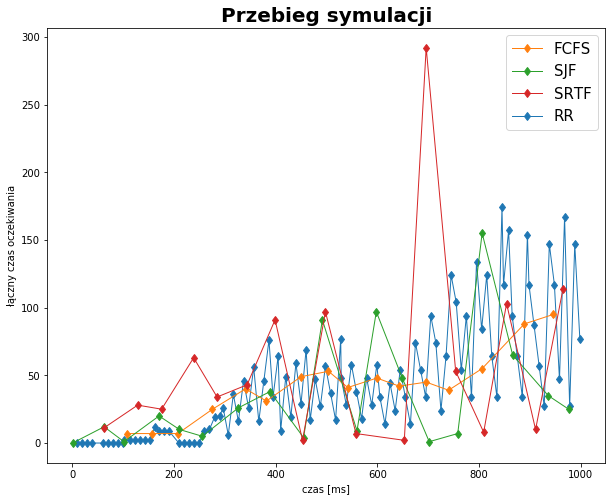

In [14]:
Test(1000, (10, 100), 'normal', 50, 10).test()

## 3
Bardzo duży rozrzut czasów wykonania szybko przybywających procesów

FCFS waiting times mean: 757.500000
SJF waiting times mean:  253.428571
SRTF waiting times mean: 223.333333
RR waiting times mean:   336.800000


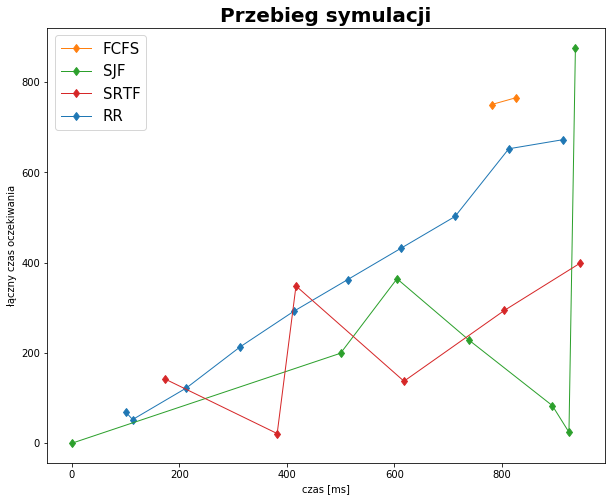

In [15]:
Test(1000, (10, 1000), 'uniform', 30, 100).test()